In [1]:
from lyrics.lyrics import (
    Domain,
    Predicate,
    Constraint,
    PointwiseConstraint,
)
from lyrics.world import current_world as world
import numpy as np
import tensorflow as tf
from sklearn import datasets as data

import matplotlib.pyplot as plt

In [2]:
np.random.seed(3)
tf.random.set_seed(3)

NB_UNSUPERVISED = 200
NB_SUPERVISED = 20
NB_TEST = 200

Create two circles where one is inside of the other

In [3]:
all_x, all_y = data.make_circles(n_samples=NB_UNSUPERVISED + NB_SUPERVISED + NB_TEST)

Take 200 unsupervised points

In [4]:
unsupervised  = all_x[0:NB_UNSUPERVISED]

Take 20 supervised points

In [5]:
sup_x, sup_y = all_x[NB_UNSUPERVISED:NB_UNSUPERVISED+NB_SUPERVISED].astype(np.float32), all_y[NB_UNSUPERVISED:NB_UNSUPERVISED+NB_SUPERVISED].reshape(-1,1).astype(np.float32)

Take 200 test points

In [6]:
test_x, test_y = all_x[-NB_TEST:].astype(np.float32), all_y[-NB_TEST:].reshape(-1,1).astype(np.float32)

Plot the unsupervised, supervised and test points

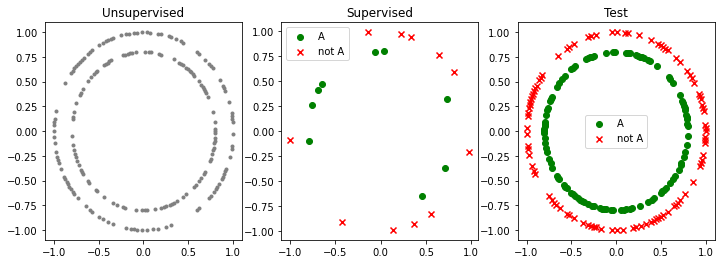

In [7]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1).title.set_text('Unsupervised')
plt.scatter(unsupervised[:,0],unsupervised[:,1], color="grey", marker=".")
plt.subplot(1,3,2).title.set_text('Supervised')
plt.scatter(sup_x[sup_y.reshape(-1,)==1][:,0],sup_x[sup_y.reshape(-1,)==1][:,1], color="green", marker="o", label="A")
plt.scatter(sup_x[sup_y.reshape(-1,)==0][:,0],sup_x[sup_y.reshape(-1,)==0][:,1], color="red", marker="x", label="not A")
plt.legend()
plt.subplot(1,3,3).title.set_text('Test')
plt.scatter(test_x[test_y.reshape(-1,)==1][:,0],test_x[test_y.reshape(-1,)==1][:,1], color="green", marker="o", label="A")
plt.scatter(test_x[test_y.reshape(-1,)==0][:,0],test_x[test_y.reshape(-1,)==0][:,1], color="red", marker="x", label="not A")
plt.legend()

plt.show()

Define a function used to say if two points are close to each other or not (we choose a thershold of .10)

In [8]:
def isClose(a, b):
    dist = tf.sqrt(tf.reduce_sum(tf.square(a - b), axis=1))
    return tf.where(dist < 0.10, tf.ones_like(dist), tf.zeros_like(dist))

Define a neural network to tell if a point is A or not A depending on it's coordinates

In [9]:
class FCL(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(FCL, self).__init__(**kwargs)
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(30, activation='relu'),
            tf.keras.layers.Dense(1)
        ])
    def call(self, inputs):
        return self.model(inputs)
    
    def cost(self, y, x):
        y_hat = self.call(x)
        losses = tf.keras.losses.binary_crossentropy(y,y_hat, from_logits=True)
        return tf.reduce_mean(losses)

Instantiate a neural network

In [10]:
fcl = FCL()

Define a point wise contraint on the supervised data. Notice that we give this constaint a weight of 100

In [11]:
ptc = PointwiseConstraint(fcl, sup_y, sup_x, weight=100)

Define a domain **points** that includes supervised and unsupervised data

In [12]:
points = Domain('points', elements=np.concatenate([unsupervised, sup_x]))

Define a logical predicate *A* where A(p) is the degree of confidence (fuzzy logic) that the point p
is of clas A. This predicate uses the previously instantiated neural network as a low-level concrete function

In [13]:
p = Predicate("A", domains=("points",), concrete_function=fcl)

Define a logical predicate CLOSE where CLOSE(p,q) is the degree of confidence that points p and q are close. This predicate uses the previously defined function isClose to as a backing function 

In [14]:
q = Predicate("CLOSE", domains=("points", "points"), concrete_function=isClose)

Define a constraint that states: for every two points: is they are close, then they should be of the same class. Notice that we give a weight of 10 to this constraint. Thus 10 times less important that the pointwise constraint

In [15]:
c = Constraint("forall p: forall q: CLOSE(p,q) -> (A(p) <-> A(q))", weight=10)

Define a standard training step. The model argument could be the pointwise constraint only or the whole constrained world. The optimization is done with respect to the neural network

In [16]:
optimizer = tf.keras.optimizers.Adam()
@tf.function
def train_step(model):
    with tf.GradientTape() as tape:
        loss = model.loss()
        grads = tape.gradient(loss, fcl.trainable_variables)
    optimizer.apply_gradients(zip(grads, fcl.trainable_weights))
    return loss

Train a model for a number of epochs

In [17]:
def train(model, nb_epochs):
    epochs = range(1,nb_epochs + 1)
    print('Loss at epoch 0 = {}'.format(model.loss()))
    for epoch in epochs:
        loss = train_step(model)
        if epoch % 1000 == 0:
            print('Loss at epoch {} = {}'.format(epoch, loss))

Train the model without the highlevel constraint (only using the pointwise constraint on the supervised data) for 5000 epochs

In [18]:
train(ptc, 5000)

Loss at epoch 0 = 68.65508270263672
Loss at epoch 1000 = 25.24232292175293
Loss at epoch 2000 = 7.050736904144287
Loss at epoch 3000 = 2.2854697704315186
Loss at epoch 4000 = 0.8955779671669006
Loss at epoch 5000 = 0.40334010124206543


Get the model's output on the supervised and test data

In [19]:
test_y_hat = (tf.math.sigmoid(fcl(test_x)) > 0.5).numpy().astype(np.int8).reshape(-1,)
sup_y_hat = (tf.math.sigmoid(fcl(sup_x)) > 0.5).numpy().astype(np.int8).reshape(-1,)

Vizualize results

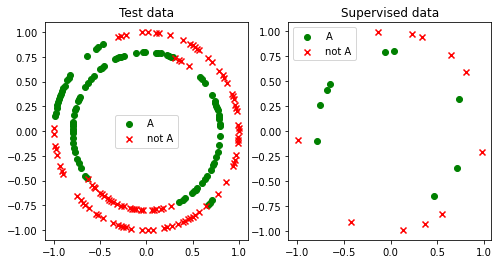

In [20]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1).title.set_text('Test data')
plt.scatter(test_x[test_y_hat==1][:,0],test_x[test_y_hat==1][:,1], color="green", marker="o", label="A")
plt.scatter(test_x[test_y_hat==0][:,0],test_x[test_y_hat==0][:,1], color="red", marker="x", label="not A")
plt.legend()
plt.subplot(1,2,2).title.set_text('Supervised data')
plt.scatter(sup_x[sup_y_hat==1][:,0],sup_x[sup_y_hat==1][:,1], color="green", marker="o", label="A")
plt.scatter(sup_x[sup_y_hat==0][:,0],sup_x[sup_y_hat==0][:,1], color="red", marker="x", label="not A")
plt.legend()
plt.show()

Continue training the model for more epochs but include the highlevel constraint

In [21]:
train(world, 2000)

Loss at epoch 0 = 393.5982971191406
Loss at epoch 1000 = 93.3553695678711
Loss at epoch 2000 = 78.73875427246094


Get the model's output on the supervised and test data

In [22]:
test_y_hat = (tf.math.sigmoid(fcl(test_x)) > 0.5).numpy().astype(np.int8).reshape(-1,)
sup_y_hat = (tf.math.sigmoid(fcl(sup_x)) > 0.5).numpy().astype(np.int8).reshape(-1,)

Vizualize results

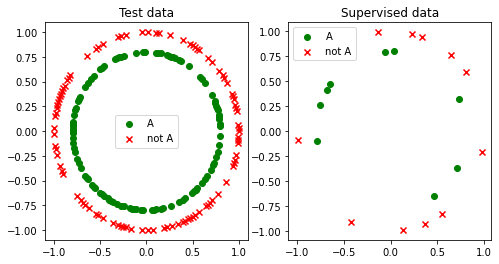

In [23]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1).title.set_text('Test data')
plt.scatter(test_x[test_y_hat==1][:,0],test_x[test_y_hat==1][:,1], color="green", marker="o", label="A")
plt.scatter(test_x[test_y_hat==0][:,0],test_x[test_y_hat==0][:,1], color="red", marker="x", label="not A")
plt.legend()
plt.subplot(1,2,2).title.set_text('Supervised data')
plt.scatter(sup_x[sup_y_hat==1][:,0],sup_x[sup_y_hat==1][:,1], color="green", marker="o", label="A")
plt.scatter(sup_x[sup_y_hat==0][:,0],sup_x[sup_y_hat==0][:,1], color="red", marker="x", label="not A")
plt.legend()
plt.show()